In [1]:
# !pip install datasets

In [2]:
import numpy as np
import os
from datasets import Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import os

def load_data(base_dir, layer='layer_24_processed'):
    embeddings = []
    labels = []
    label_map = {}
    current_label = 0

    for speaker_dir in os.listdir(base_dir):
        layer_dir = os.path.join(base_dir, speaker_dir, layer)
        speaker_embeddings = []

        if os.path.isdir(layer_dir):
            for file_name in os.listdir(layer_dir):
                if file_name.endswith('.npy'):
                    path = os.path.join(layer_dir, file_name)
                    embedding = np.load(path)
                    speaker_embeddings.append(embedding)

            # Append each embedding separately to the main list
            for emb in speaker_embeddings:
                embeddings.append(emb)
                # Check if the speaker has a label assigned, if not assign one
                if speaker_dir not in label_map:
                    label_map[speaker_dir] = current_label
                    current_label += 1
                # Append the label corresponding to the speaker for each embedding
                labels.append(label_map[speaker_dir])

    # Convert list of embeddings and labels to numpy arrays for further processing
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels

# Example usage
base_dir = '/content/drive/My Drive/NLP/clips__test/'
embeddings, labels = load_data(base_dir)


In [5]:
# Reshape data if necessary (assuming each .npy file contains data in a form that can be input directly into a CNN)
# Example: reshaping to fit a simple CNN expecting inputs of shape (height, width, channels)
# embeddings = embeddings.reshape(embeddings.shape[0], height, width, channels)

# Encode labels to one-hot vectors
labels = to_categorical(labels)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.1, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

In [6]:
#y_test.shape

In [7]:
#!pip install tensorflow-addons

In [8]:

X_train = X_train.reshape(-1, 100, 1024, 1)  # Assuming your data is in (batch_size, 1, 100, 1024)
X_val = X_val.reshape(-1, 100, 1024, 1)
#X_test = X_test.reshape(-1, 100, 1024, 1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, regularizers

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
    #    layers.Dropout(0.25),  # Dropout hinzufügen
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2-Regularisierung
   #     layers.Dropout(0.5),  # Mehr Dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Example adjustment: reshape your data appropriately before using this function
# Make sure `X_train` is reshaped if necessary
# input_shape = (height, width, channels)
input_shape = (100, 1024, 1)  # Now it matches the reshaped data
num_classes = y_val.shape[1]
model = build_model(input_shape, num_classes)




In [10]:
from tensorflow.keras import models, layers
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Assuming model has been defined and compiled as per previous steps
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=20,  # Adjust based on your memory capacity and training needs
                    validation_data=(X_val, y_val))

# Now use the model to predict, not the history object
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')  # You can change average mode

print(f"F1 Score: {f1}")
print(classification_report(y_true_classes, y_pred_classes))


Epoch 1/20
583/583 [==============================] - 17s 24ms/step - loss: 3.0022 - accuracy: 0.0688 - val_loss: 2.9658 - val_accuracy: 0.0664
Epoch 2/20
583/583 [==============================] - 13s 22ms/step - loss: 2.7544 - accuracy: 0.1442 - val_loss: 2.3284 - val_accuracy: 0.2894
Epoch 3/20
583/583 [==============================] - 13s 22ms/step - loss: 2.0031 - accuracy: 0.3423 - val_loss: 1.7149 - val_accuracy: 0.4529
Epoch 4/20
583/583 [==============================] - 13s 22ms/step - loss: 1.7307 - accuracy: 0.4414 - val_loss: 1.5787 - val_accuracy: 0.5085
Epoch 5/20
583/583 [==============================] - 13s 22ms/step - loss: 1.5864 - accuracy: 0.4874 - val_loss: 1.5167 - val_accuracy: 0.5054
Epoch 6/20
583/583 [==============================] - 13s 22ms/step - loss: 1.4398 - accuracy: 0.5276 - val_loss: 1.4444 - val_accuracy: 0.5093
Epoch 7/20
583/583 [==============================] - 13s 22ms/step - loss: 1.3703 - accuracy: 0.5465 - val_loss: 1.3452 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save('/content/drive/My Drive/NLP/models/layer_0_model.keras')

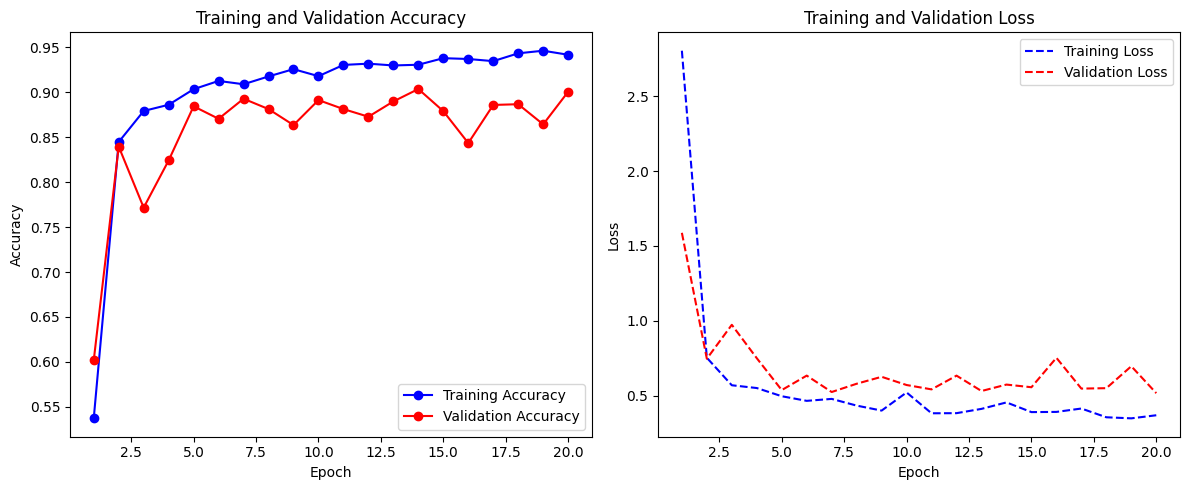

In [11]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 21))
train_accuracy = [
    0.7191, 0.9259, 0.9481, 0.9546, 0.9692, 0.9699, 0.9719, 0.9790,
    0.9798, 0.9835, 0.9836, 0.9869, 0.9869, 0.9878, 0.9884, 0.9919,
    0.9893, 0.9931, 0.9887, 0.9919
]
val_accuracy = [
    0.9082, 0.8897, 0.9329, 0.9205, 0.9375, 0.9475, 0.9005, 0.9390,
    0.9352, 0.9282, 0.9113, 0.9444, 0.9213, 0.9406, 0.9398, 0.9352,
    0.9236, 0.9406, 0.9352, 0.9437
]
train_loss = [
    0.9843, 0.2018, 0.1404, 0.1208, 0.0846, 0.0819, 0.0764, 0.0549,
    0.0571, 0.0506, 0.0473, 0.0379, 0.0434, 0.0368, 0.0341, 0.0245,
    0.0318, 0.0217, 0.0369, 0.0263
]
val_loss = [
    0.2991, 0.3339, 0.2040, 0.2322, 0.1821, 0.2053, 0.4248, 0.2368,
    0.2807, 0.2846, 0.3664, 0.2325, 0.2619, 0.2848, 0.2748, 0.3332,
    0.2691, 0.3643, 0.3651, 0.2863
]

# Arrays for training and validation loss
train_loss = [
    2.8055, 0.7526, 0.5688, 0.5502, 0.4954, 0.4645, 0.4776,
    0.4328, 0.3994, 0.5207, 0.3814, 0.3822, 0.4109, 0.4541,
    0.3893, 0.3906, 0.4132, 0.3547, 0.3476, 0.3682
]

# Arrays for training and validation accuracy
train_accuracy = [
    0.5373, 0.8446, 0.8791, 0.8860, 0.9033, 0.9125, 0.9088,
    0.9175, 0.9256, 0.9178, 0.9303, 0.9317, 0.9297, 0.9305,
    0.9378, 0.9369, 0.9345, 0.9432, 0.9461, 0.9416
]

# Arrays for validation loss
val_loss = [
    1.5880, 0.7462, 0.9730, 0.7497, 0.5365, 0.6333, 0.5236,
    0.5789, 0.6254, 0.5704, 0.5412, 0.6331, 0.5303, 0.5733,
    0.5556, 0.7523, 0.5464, 0.5493, 0.6959, 0.5159
]

# Arrays for validation accuracy
val_accuracy = [
    0.6019, 0.8395, 0.7716, 0.8241, 0.8843, 0.8704, 0.8927,
    0.8812, 0.8634, 0.8912, 0.8812, 0.8727, 0.8897, 0.9035,
    0.8789, 0.8434, 0.8858, 0.8866, 0.8642, 0.9005
]


plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


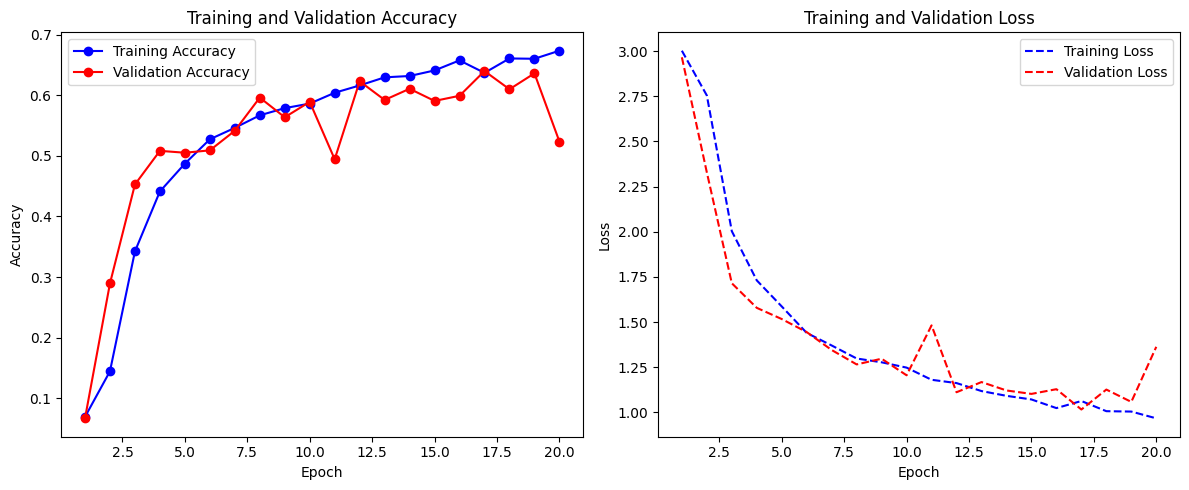

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))
#Layer_24
# Arrays for training and validation loss
train_losses = [
    3.0022, 2.7544, 2.0031, 1.7307, 1.5864, 1.4398, 1.3703,
    1.2983, 1.2772, 1.2478, 1.1804, 1.1622, 1.1180, 1.0916,
    1.0716, 1.0237, 1.0629, 1.0066, 1.0045, 0.9670
]

# Arrays for training and validation accuracy
train_accuracies = [
    0.0688, 0.1442, 0.3423, 0.4414, 0.4874, 0.5276, 0.5465,
    0.5672, 0.5791, 0.5866, 0.6045, 0.6166, 0.6300, 0.6322,
    0.6414, 0.6580, 0.6374, 0.6612, 0.6607, 0.6740
]

# Arrays for validation loss
val_losses = [
    2.9658, 2.3284, 1.7149, 1.5787, 1.5167, 1.4444, 1.3452,
    1.2655, 1.2971, 1.2053, 1.4816, 1.1115, 1.1678, 1.1213,
    1.1023, 1.1284, 1.0159, 1.1263, 1.0580, 1.3630
]

# Arrays for validation accuracy
val_accuracies = [
    0.0664, 0.2894, 0.4529, 0.5085, 0.5054, 0.5093, 0.5417,
    0.5965, 0.5640, 0.5895, 0.4946, 0.6235, 0.5926, 0.6111,
    0.5910, 0.5995, 0.6404, 0.6103, 0.6366, 0.5239
]

plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b--', label='Training Loss')
plt.plot(epochs, val_losses, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load a saved model
loaded_model = load_model('/content/drive/My Drive/NLP/models/layer_0_model.keras')

In [ ]:

import pandas as pd

# Convert the history dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(loaded_model.history)

# Display the DataFrame
print(metrics_df)


Empty DataFrame
Columns: []
Index: []


In [17]:
!pip install numba

In [18]:
from numba import cuda
device = cuda.get_current_device()
device.reset()